In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product
import sys
plt.style.use("seaborn")

In [73]:
df = yf.download("TSLA", start="2010-01-01", end="2020-04-30")

[*********************100%***********************]  1 of 1 completed


In [85]:
class SMABacktester():
    
    ''' Class for vectorized backtesting of SMA-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end):
        
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for Longer SMA
        start: str
            start date for data import
        end: str
            end date for data import
        '''
        
        self.symbol=symbol
        self.SMA_S=SMA_S
        self.SMA_L=SMA_L
        self.start=start
        self.end=end
        self.results=None
        self.get_data()
    
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    
    def get_data(self):
        ''' Imports the data from forex_pairs.csv (source can be changed).
        '''
        raw = pd.read_csv("/Users/ahsan/Dropbox/My Mac (Alnoors-MBP-2.hub)/Documents/github/AlgoTrading/Part3_Materials/forex_pairs.csv", parse_dates=['Date'], index_col='Date')
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        raw['SMA_S'] = raw['price'].rolling(self.SMA_S).mean()
        raw['SMA_L'] = raw['price'].rolling(self.SMA_L).mean()
        self.data = raw
        
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data
        
    
    def set_parameters(self, SMA_S=None, SMA_L=None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S=SMA_S
            self.data['SMA_S'] = self.data['price'].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L=SMA_L
            self.data['SMA_L'] = self.data['price'].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA_S'] > data['SMA_L'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace=True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        
        # abs perf
        perf = data['cstrategy'].iloc[-1]
        # out perf
        outperf = perf - data['creturns'].iloc[-1]
        return round(perf, 6), round(outperf, 6)

    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(12,8))
    
    
    def set_signals(self, l_buy, l_sell, data):
        
        ''' Sets the buy and sell signals into the dataframe.
            This is a helper function for plot_optimize_graph
        '''
        
        # Buy and Sell Tickers
        # For long --> buy_long, sell_long
        flag = 1
        for i in range(len(data)):
            if data['SMA_S'].iloc[i] > data['SMA_L'].iloc[i] and flag==1:
                l_buy.append(data['price'].iloc[i])
                l_sell.append(np.nan)
                flag=-1
            elif data['SMA_S'][i] < data['SMA_L'].iloc[i] and flag==-1:
                l_sell.append(data['price'].iloc[i])
                l_buy.append(np.nan)
                flag=1
            else:
                l_buy.append(np.nan)
                l_sell.append(np.nan)
        data['l_buy'], data['l_sell'] = l_buy, l_sell
    
    def plot_optimized_graph(self):
        ''' Plots the graph with buy and sell signals for the optimized strategy
        '''
        if self.results is None:
            print("Run optimize_parameters() first")
            sys.exit()
        
        data = self.data.copy().dropna()
        l_buy = []
        l_sell = []
        self.set_signals(l_buy, l_sell, data)
        
        plt.figure(figsize=(20,15))
        # Buy and sell tickers
        plt.scatter(data.index, data['l_buy'], color='green', label='Buy Signal', marker='^', alpha=1)
        plt.scatter(data.index, data['l_sell'], color='red', label='Sell Signal', marker='v', alpha=1)
        # Chart
        plt.plot(data[['price', 'SMA_S', 'SMA_L']],  label=['price', 'SMA{}'.format(self.SMA_S), 'SMA{}'.format(self.SMA_L)], alpha = 0.35)
        plt.title('TESLA/USD - SMA{} | SMA{}'.format(self.SMA_S, self.SMA_L))
        plt.ylabel('Close Price USD ($)',fontsize=18)
        plt.legend( loc='upper left')
        plt.show()
    
    
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
        
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
                            
        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]
                            
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                            
        many_results = pd.DataFrame(data = combinations, columns=['SMA_S', 'SMA_L'])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf

In [75]:
# Instance of backtester class
tester = SMABacktester("EURUSD=X", 50, 200, "2004-01-01", "2020-06-30")

In [76]:
# Checking data attribute
tester.data

,price,returns,SMA_S,SMA_L
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430
2020-06-25,1.125087,-0.005449,1.102486,1.103540
2020-06-26,1.122208,-0.002562,1.103213,1.103627


In [77]:
# Testing strategy
tester.test_strategy()

(1.2835, 0.367674)

In [78]:
# Checking results
tester.results

,price,returns,SMA_S,SMA_L,position,strategy,creturns,cstrategy
Date,,,,,,,,
2004-10-07,1.229906,0.001475,1.221840,1.226081,-1,-0.001475,1.001476,0.998526
2004-10-08,1.241003,0.008982,1.222628,1.225995,-1,-0.008982,1.010511,0.989598
2004-10-11,1.238405,-0.002095,1.223352,1.225843,-1,0.002095,1.008396,0.991673
2004-10-12,1.232104,-0.005102,1.223888,1.225643,-1,0.005102,1.003265,0.996746
2004-10-13,1.234903,0.002270,1.224466,1.225497,-1,-0.002270,1.005545,0.994486
...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.103430,-1,-0.002892,0.921130,1.271272
2020-06-25,1.125087,-0.005449,1.102486,1.103540,-1,0.005449,0.916125,1.278218
2020-06-26,1.122208,-0.002562,1.103213,1.103627,-1,0.002562,0.913781,1.281497


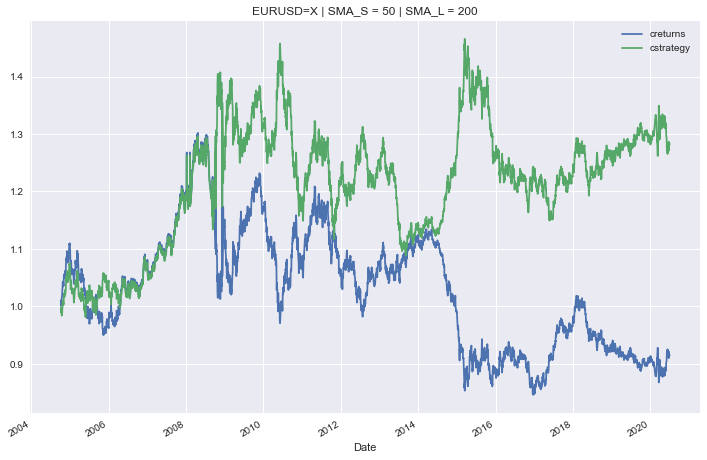

In [79]:
# Plotting results
tester.plot_results()

In [80]:
tester.optimize_parameters((10, 50, 1), (100, 252, 1))

((46, 137), 2.526694)

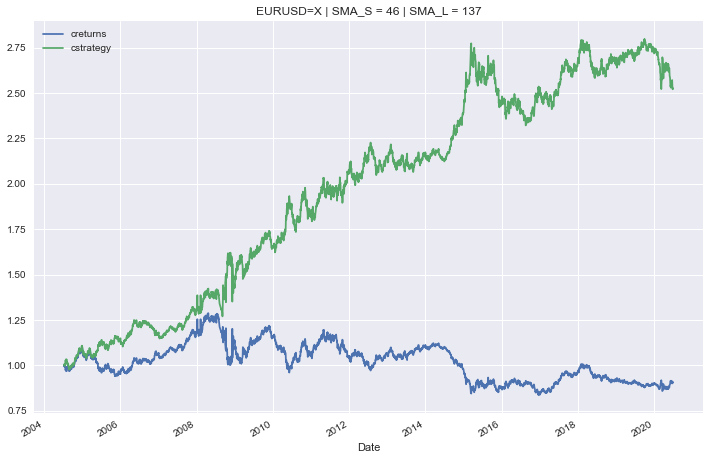

In [81]:
tester.plot_results()

In [82]:
tester.results_overview

,SMA_S,SMA_L,performance
0,10,100,0.919640
1,10,101,0.901791
2,10,102,0.908851
3,10,103,0.917204
4,10,104,0.990232
...,...,...,...
6075,49,247,1.282403
6076,49,248,1.303129
6077,49,249,1.267525
6078,49,250,1.275176


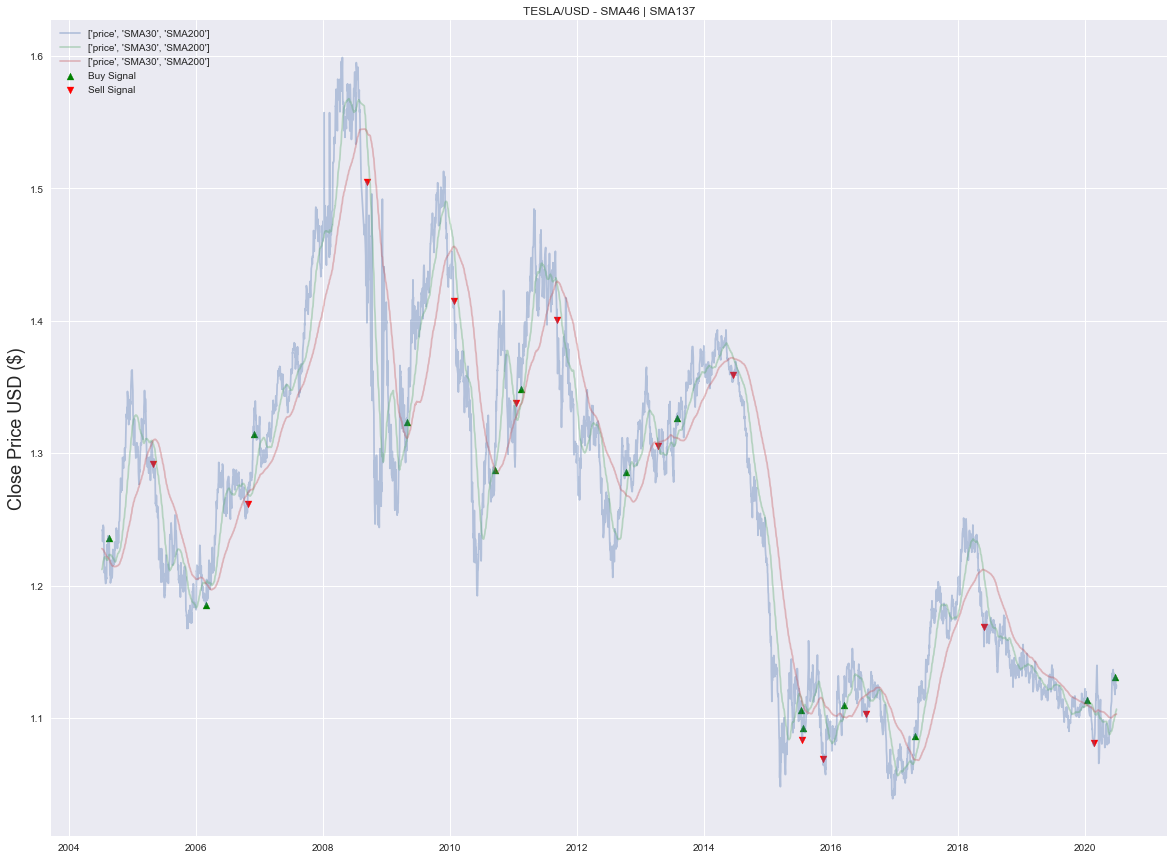

In [84]:
tester.plot_optimized_graph()